###  Spectral Clustering

Spectral clustering is based on graph theory, where the sample data are mapped to a $n \times n$ array that describes the degree of pairwise 'connectivity' between the sample data, and then Eigen vectors are calculated to reduce the dimensionality and k-means clustering is applied on the retained Eigen vectors to find the clusters.

The advantages of the method includes:

* the ability to encode connectivity between the samples in the dataset. While kernel and nearest neightbour approaches are common to determine connectivity, this step could include integration of various information sources.  

* the Eigen values provide useful diagnostic information to inform the number of natural clusters based on the degree of cutting of connection required to separate the dataset

* the Eigen vectors provide reduced dimensional representations of the high dimensional representation of pairwise connection

**Other Resources** - I found the short article with demonstration on [Spectral Clustering](https://towardsdatascience.com/spectral-clustering-aba2640c0d5b) by William Fleshman quite useful to understand this approach. 

These are the steps for spectral clustering:

* **Calculate the Simularity Graph and Matrix**

* **Calculate the Degree Matrix**

* **Calculate the Graph Laplacian Matrix**

* **Perform Dimensionality Reduction on the Graph Laplacian Matrix**

* **Assign Clusters in the Reduced Dimensionality**

##### Calculate the Simularity Graph and Matrix

Spectral clustering first calculates a graph of the data in predictor space

* a graph is comprised of the samples (nodes) and connections (edges/vertices) between the samples

There are mulitple methods to represent the sample data graph in predictor feature space:

* **affinity matrix** the connections are represented as an $n \times n$ matrix with 0 if no connection and a measure of similarity for connected samples. This is accomplished with radial basis function kernel with a specified gamma, or other kernels such as polynomial.

* **adjacency matrix** the connections are represented as a $n \times n$ matrix with 0 if no connection and 1 if connected.  This matrix may be calculated with k-nearest neighbor (up to a determined maximum number of neighbors), epsilon-neighborhood (all points withing a radius) or radial basis function kernel with a specified gamma, or other kernels such as polynomial. 

##### Calculate the Degree Matrix

The degree matrix is a diagonal matrix where elements $[i,i]$ are the summation of the adjacency matrix row $i$.

##### Calculate the Graph Laplacian Matrix 

The graph Laplacian is the adjacency matrix subtracted from the degree matrix.

##### Perform Dimensionality Reduction on the Graph Laplacian Matrix

Calculate the Eigen Values and Eigen Vectors of the Graph Laplacian matrix. The result is $n$ Eigen vectors (of length $n$) and $n$ Eigen values.  We can interprete the Eigen values / vectors as follows:

* the number of zero Eigen values are the number of connected parts of the dataset.  For example, when the simularity graph indicates 0 similarity for all sample data to sample data combinations, all Eigen values are 0, all sample data are independent connected parts. If all data are connected, then all Eigen values except for the first are nonzero, indicating all sample data in one connected part.

* the first nonzero Eigen value is the **spectral gap**. It provides an indication of the density of the sample to sample connections. For example, if the affinity is 1.0 for all sample data pairs, the spectral gap is equal to $n$.

* the second Eigen value is the **Fiedler value** and the associated Eigen vector is the **Fiedler vector**. It indicates the level of graph cut to separate the sample dataset into 2 parts. For example, if the second Eigen value is 0 already, then the dataset is already separated into atleast 2 parts; therefore, no cuts are needed!

##### Assign Clusters in the Reduced Dimensionality

The final step is to assign the clusters based on the result from the dimensionality reduced graph Laplacian matrix.  There are a couple of methods possible demonstrated here:

1. We can use the Eigen values to determine the number of clusters:

* jumps in Eigen values are used to identify the natural number of clusters in the dataset. i.e. if we add another connected group we would have to do a lot more cuts!

2. Assignment of clusters by Eigen vector values:

* the sign of the Fiedler vector provides the 2 custers (positive and negative) if the dataset where cut into 2 groups.

3. Assignment of clusters by k-means clustering applied to the Eigen vectors 

* we apply k-means clustering on the Eigen vectors up to the determined number of clusters. This finds the groups asessed while integrating pairwise connections of the sample data.

#### Objective 

In the PGE 383: Subsurface Machine Learning class I want to provide hands-on experience with building subsurface modeling workflows. Python provides an excellent vehicle to accomplish this. I have coded a package called GeostatsPy with GSLIB: Geostatistical Library (Deutsch and Journel, 1998) functionality that provides basic building blocks for building subsurface modeling workflows. 

The objective is to remove the hurdles of subsurface modeling workflow construction by providing building blocks and sufficient examples. This is not a coding class per se, but we need the ability to 'script' workflows working with numerical methods.    

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

You will need to copy the data file to your working directory.  They are available here:

* Tabular data - unconv_MV.csv at https://git.io/fjmBH.

There are exampled below with these functions. You can go here to see a list of the available functions, https://git.io/fh4eX, other example workflows and source code. 

#### Install Packages

We will include the standard packages for DataFrames and ndarrays and add scikit-learn (sklearn) for machine learning and ipywidgets for interactivity.

We will also need some standard packages. These should have been installed with Anaconda 3.

In [1]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import copy                               # for deep copies
import math                               # for square root function
from sklearn.neighbors import NearestNeighbors # nearest neighbours function to calculate eps hyperparameter
from sklearn.preprocessing import MinMaxScaler # min/max normalization
from sklearn.cluster import KMeans        # k-means clustering
from sklearn.cluster import DBSCAN        # DBSCAN clustering
from sklearn.cluster import SpectralClustering # spectral clustering
from ipywidgets import interactive        # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
cmap = plt.cm.inferno                     # color map with tone and intensity change

#### Specifying Data

Let's specify a small dataset with arbitrary $X_1$ and $X_2$ features. 

* we can easily edit the data to explore the behavoir of spectral clustering

* the can run the approach fast enough to itneractive with the system in realtime

We will also calculate the:

* **adjacency matrix** - we will asumme a radius to efficiently find the linkages

* **degree matrix** - the sum of connections for each sample data as a diagnonal matrix

* **graph Laplacian matrix** - the adjacency matrix subtracted from the degree matrix  

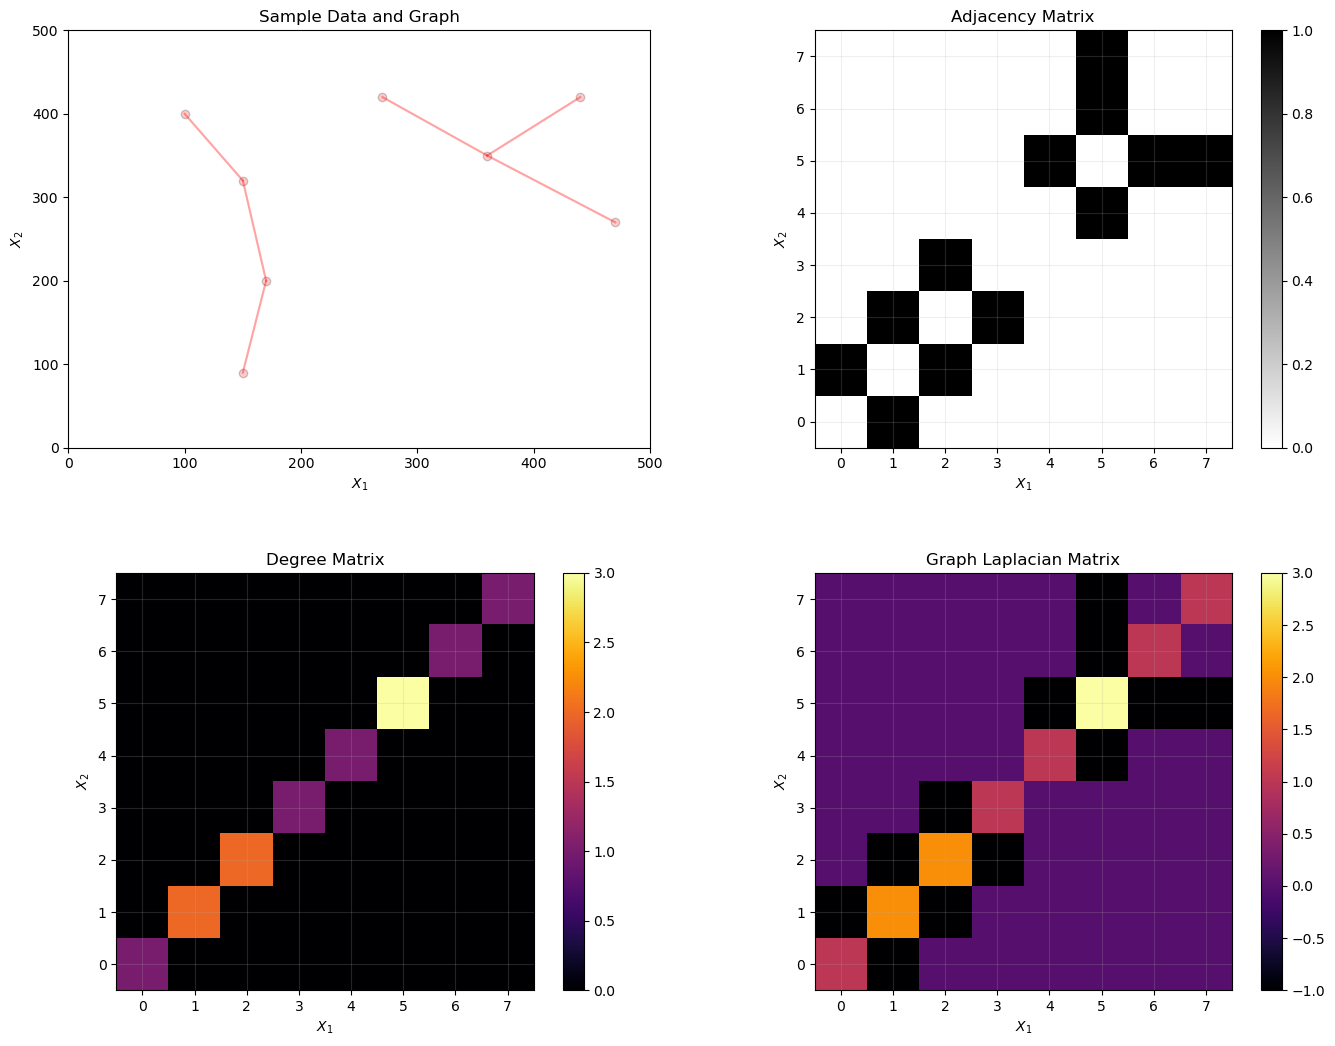

In [2]:
# specify the sample data
X1 = [100,150,170,150,270,360,440,470]; X2 = [400,320,200,90,420,350,420,270] # made up small dataset, 2 paired features


radius = 150                              # specify the feature distance for pairwise connections

adjacency = np.zeros([len(X1),len(X1)])   # declare the 2D matrices
degree = np.zeros([len(X1),len(X2)])

# populate the adjacency matrix
for j in range(0,len(X1)):
    for i in range(0,len(X1)):
        if i != j:
            distance = math.sqrt((X1[i]-X1[j])*(X1[i]-X1[j]) + (X2[i]-X2[j])*(X2[i]-X2[j]))
            if distance <= radius:
                adjacency[i,j] = 1; adjacency[j,i] = 1 

# plot the adjacency matrix
plt.subplot(222)  
plt.imshow(adjacency,cmap = plt.cm.binary); plt.grid(alpha = 0.2)
plt.xlim([-0.5,len(X1)-1+0.5]); plt.ylim([-0.5,len(X2)-1+0.5]);
plt.title('Adjacency Matrix'); plt.xlabel('$X_1$'); plt.ylabel('$X_2$');
plt.colorbar()

# populate the degree matrix
for j in range(0,len(X1)):
    summation = 0
    for i in range(0,len(X1)):
        summation = summation + adjacency[i,j]
    degree[j,j] = summation
    
# plot the degree matrix
plt.subplot(223)  
plt.imshow(degree,cmap = cmap); plt.grid(alpha = 0.2)
plt.xlim([-0.5,len(X1)-1+0.5]); plt.ylim([-0.5,len(X2)-1+0.5]);
plt.title('Degree Matrix'); plt.xlabel('$X_1$'); plt.ylabel('$X_2$');
plt.colorbar() 
    
# calculate the Laplacian matrix
Laplace = degree - adjacency

# plot the Laplacian matrix
plt.subplot(224)  
plt.imshow(Laplace,cmap = cmap); plt.grid(alpha = 0.2)
plt.xlim([-0.5,len(X1)-1+0.5]); plt.ylim([-0.5,len(X2)-1+0.5]);
plt.title('Graph Laplacian Matrix'); plt.xlabel('$X_1$'); plt.ylabel('$X_2$');
plt.colorbar()
    
# plot the sample data graph
plt.subplot(221)
plt.scatter(X1,X2,c = 'red',alpha = 0.2,edgecolors = 'black')
for j in range(0,len(X1)):
    for i in range(0,len(X1)):
        if adjacency[i,j] == 1:
            x1 = [X1[i],X1[j]]; x2 = [X2[i],X2[j]]
            plt.plot(x1,x2,c = 'red',alpha = 0.2)
plt.xlim([0,500]); plt.ylim([0,500]); 
plt.xlabel('$X_1$'); plt.ylabel('$X_2$'); plt.title('Sample Data and Graph')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.2, hspace=0.3)        

#### Eigen Vectors and Values

Let's calculate the Eigen vectors and values with the NumPy package

```python
vals, vecs = np.linalg.eig(Laplace)             
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]
```

Note, NumPy's [argsort](https://numpy.org/devdocs/reference/generated/numpy.argsort.html) returns an int 1D ndarray iwth the indices that sort on value. This sorts the Eigen values and Eigen vectors in order of ascending Eigen value.

* i.e. first Eigen vector and value has the lowest Eigen value

* code taken from this [article and demonstration](https://towardsdatascience.com/spectral-clustering-aba2640c0d5b)

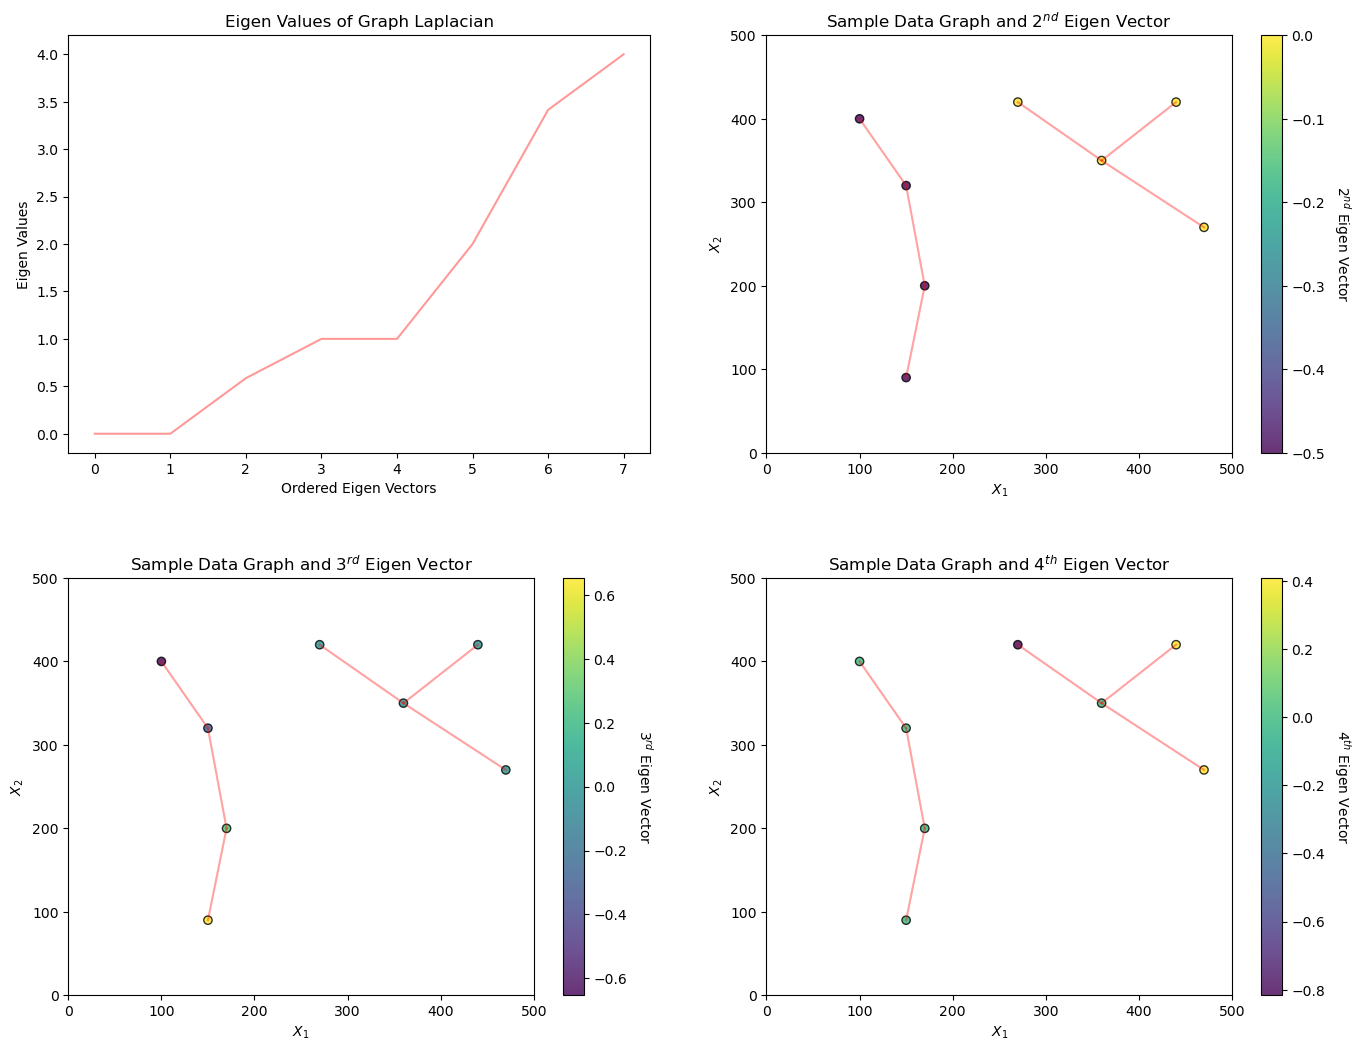

In [3]:
# calculate the Eigen values and vectors and sort by Eigen value
vals, vecs = np.linalg.eig(Laplace)
vecs = vecs[:,np.argsort(vals)]
vals = vals[np.argsort(vals)]

# plot the sorted Eigen values
plt.subplot(221)
plt.plot(vals,c = 'red',alpha = 0.4); 
plt.title('Eigen Values of Graph Laplacian'); plt.ylabel('Eigen Values'); plt.xlabel('Ordered Eigen Vectors')

# plot the sample data graph with 2nd Eigen vector
plt.subplot(222)
plt.scatter(X1,X2,c = vecs[:,1],alpha = 0.8,edgecolors = 'black')
for j in range(0,len(X1)):                 # plot vertices 
    for i in range(0,len(X1)):
        if adjacency[i,j] == 1:
            x1 = [X1[i],X1[j]]; x2 = [X2[i],X2[j]]
            plt.plot(x1,x2,c = 'red',alpha = 0.2)
plt.xlim([0,500]); plt.ylim([0,500]); 
plt.xlabel('$X_1$'); plt.ylabel('$X_2$'); plt.title('Sample Data Graph and $2^{nd}$ Eigen Vector')
cbar = plt.colorbar()
cbar.set_label('$2^{nd}$ Eigen Vector', rotation=270, labelpad=20)

# plot the sample data graph with 3rd Eigen vector
plt.subplot(223)
plt.scatter(X1,X2,c = vecs[:,2],alpha = 0.8,edgecolors = 'black')
for j in range(0,len(X1)):                 # plot vertices
    for i in range(0,len(X1)):
        if adjacency[i,j] == 1:
            x1 = [X1[i],X1[j]]; x2 = [X2[i],X2[j]]
            plt.plot(x1,x2,c = 'red',alpha = 0.2)
plt.xlim([0,500]); plt.ylim([0,500]); 
plt.xlabel('$X_1$'); plt.ylabel('$X_2$'); plt.title('Sample Data Graph and $3^{rd}$ Eigen Vector')
cbar = plt.colorbar()
cbar.set_label('$3^{rd}$ Eigen Vector', rotation=270, labelpad=20)

# plot the sample data graph with 4th Eigen vector
plt.subplot(224)
plt.scatter(X1,X2,c = vecs[:,3],alpha = 0.8,edgecolors = 'black') 
for j in range(0,len(X1)):                 # plot vertices
    for i in range(0,len(X1)):
        if adjacency[i,j] == 1:
            x1 = [X1[i],X1[j]]; x2 = [X2[i],X2[j]]
            plt.plot(x1,x2,c = 'red',alpha = 0.2)
plt.xlim([0,500]); plt.ylim([0,500]); 
plt.xlabel('$X_1$'); plt.ylabel('$X_2$'); plt.title('Sample Data Graph and $4^{th}$ Eigen Vector')
cbar = plt.colorbar()
cbar.set_label('$4^{th}$ Eigen Vector', rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.2, hspace=0.3)      

#### Assign Clusters by k-Means Clusters on Eigen Vectors

Now we will apply k-Means clusters on the first k vectors where k is the number of clusters.

* code taken from this [article and demonstration](https://towardsdatascience.com/spectral-clustering-aba2640c0d5b)

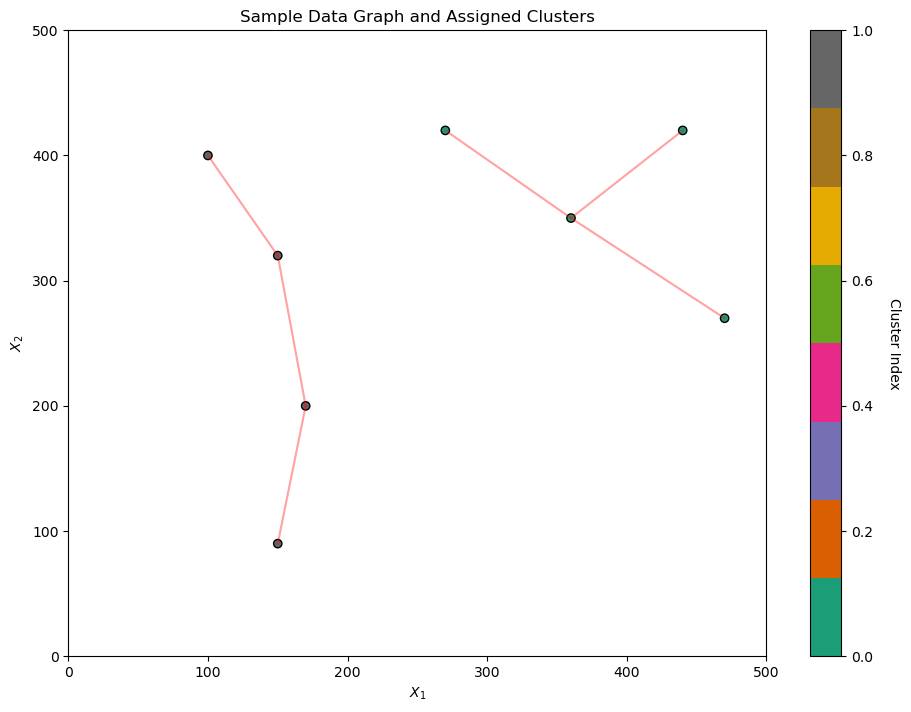

In [4]:
k = 2                                     # set the number of clusters
kmeans = KMeans(n_clusters=k)             # instantiate k-means clusters
kmeans.fit(vecs[:,1:k])                   # fit k-means clusters
clusters = kmeans.labels_

# plot the sample data graph with 2nd Eigen vector
plt.subplot(222)
for j in range(0,len(X1)):                 # plot vertices
    for i in range(0,len(X1)):
        if adjacency[i,j] == 1:
            x1 = [X1[i],X1[j]]; x2 = [X2[i],X2[j]]
            plt.plot(x1,x2,c = 'red',alpha = 0.2)
plt.scatter(X1,X2,c = clusters,alpha = 1.0,edgecolors = 'black',vmin = 0, vmax = k-1, cmap = plt.cm.Dark2)
plt.xlim([0,500]); plt.ylim([0,500]); 
plt.xlabel('$X_1$'); plt.ylabel('$X_2$'); plt.title('Sample Data Graph and Assigned Clusters')
cbar = plt.colorbar()
cbar.set_label('Cluster Index', rotation=270, labelpad=20)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.0, wspace=0.2, hspace=0.3)  

#### Interactive Spectral Clustering Method

The following code includes:

* dashboard with number of clusters, variogram model sample locations in the feature space and the radius for connections 

* plots the Eigen values, 2nd Eigen vector and clusters

In [5]:
import warnings; warnings.simplefilter('ignore')

color = ['blue','red','green','yellow','orange','white','magenta','cyan']

style = {'description_width': 'initial'}
l = widgets.Text(value='                                              Spectral Clustering',layout=Layout(width='950px', height='30px'))
ncluster = widgets.IntSlider(min = 2, max = 8, value = 2, step = 1, description = 'nclusters',orientation='vertical',
                          layout=Layout(width='100px', height='200px'))
ncluster.style.handle_color = 'gray'

radius = widgets.FloatSlider(min=0.0, max = 1000.0, value = 50.0, step = 10.0, description = 'radius',
                        orientation='vertical',layout=Layout(width='100px', height='200px'))
radius.style.handle_color = 'gray'
   
x1 = widgets.FloatSlider(min=0.0, max = 500.0, value = X1[0], step = 1.0, description = '$x_1$',orientation='vertical',
                         layout=Layout(width='30px', height='200px'),readout_format = '.0f',style=style)
x1.style.handle_color = color[0]
y1 = widgets.FloatSlider(min=0.0, max = 500.0, value = X2[0], step = 1.0, description = '$y_1$',orientation='vertical',
                         layout=Layout(width='30px', height='200px'),readout_format = '.0f',style=style)
y1.style.handle_color = color[0]

x2 = widgets.FloatSlider(min=0.0, max = 500.0, value = X1[1], step = 1.0, description = '$x_2$',orientation='vertical',
                         layout=Layout(width='30px', height='200px'),readout_format = '.0f',style=style)
x2.style.handle_color = color[1]
y2 = widgets.FloatSlider(min=0.0, max = 500.0, value = X2[1], step = 1.0, description = '$y_2$',orientation='vertical',
                         layout=Layout(width='30px', height='200px'),readout_format = '.0f',style=style)
y2.style.handle_color = color[1]

x3 = widgets.FloatSlider(min=0.0, max = 500.0, value = X1[2], step = 1.0, description = '$x_3$',orientation='vertical',
                         layout=Layout(width='30px', height='200px'),readout_format = '.0f',style=style)
x3.style.handle_color = color[2]
y3 = widgets.FloatSlider(min=0.0, max = 500.0, value = X2[2], step = 1.0, description = '$y_3$',orientation='vertical',
                         layout=Layout(width='30px', height='200px'),readout_format = '.0f',style=style)
y3.style.handle_color = color[2]

x4 = widgets.FloatSlider(min=0.0, max = 500.0, value = X1[3], step = 1.0, description = '$x_4$',orientation='vertical',
                         layout=Layout(width='30px', height='200px'),readout_format = '.0f',style=style)
x4.style.handle_color = color[3]
y4 = widgets.FloatSlider(min=0.0, max = 500.0, value = X2[3], step = 1.0, description = '$y_4$',orientation='vertical',
                         layout=Layout(width='30px', height='200px'),readout_format = '.0f',style=style)
y4.style.handle_color = color[3]

x5 = widgets.FloatSlider(min=0.0, max = 500.0, value = X1[4], step = 1.0, description = '$x_5$',orientation='vertical',
                         layout=Layout(width='30px', height='200px'),readout_format = '.0f',style=style)
x5.style.handle_color = color[4]
y5 = widgets.FloatSlider(min=0.0, max = 500.0, value = X2[4], step = 1.0, description = '$y_5$',orientation='vertical',
                         layout=Layout(width='30px', height='200px'),readout_format = '.0f',style=style)
y5.style.handle_color = color[4]

x6 = widgets.FloatSlider(min=0.0, max = 500.0, value = X1[5], step = 1.0, description = '$x_6$',orientation='vertical',
                         layout=Layout(width='30px', height='200px'),readout_format = '.0f',style=style)
x6.style.handle_color = color[5]
y6 = widgets.FloatSlider(min=0.0, max = 500.0, value = X2[5], step = 1.0, description = '$y_6$',orientation='vertical',
                         layout=Layout(width='30px', height='200px'),readout_format = '.0f',style=style)
y6.style.handle_color = color[5]

x7 = widgets.FloatSlider(min=0.0, max = 500.0, value = X1[6], step = 1.0, description = '$x_7$',orientation='vertical',
                         layout=Layout(width='30px', height='200px'),readout_format = '.0f',style=style)
x7.style.handle_color = color[6]
y7 = widgets.FloatSlider(min=0.0, max = 500.0, value = X2[6], step = 1.0, description = '$y_7$',orientation='vertical',
                         layout=Layout(width='30px', height='200px'),readout_format = '.0f',style=style)
y7.style.handle_color = color[6]

x8 = widgets.FloatSlider(min=0.0, max = 500.0, value = X1[7], step = 1.0, description = '$x_8$',orientation='vertical',
                         layout=Layout(width='30px', height='200px'),readout_format = '.0f',style=style)
x8.style.handle_color = color[7]
y8 = widgets.FloatSlider(min=0.0, max = 500.0, value = X2[7], step = 1.0, description = '$y_8$',orientation='vertical',
                         layout=Layout(width='30px', height='200px'),readout_format = '.0f',style=style)
y8.style.handle_color = color[7]

uipars = widgets.HBox([ncluster,radius,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8],) 
uik = widgets.VBox([l,uipars],)

def f_make_spectral(ncluster,radius,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8):                       # function to take parameters, make sample and plot#
#    text_trap = io.StringIO()
#    sys.stdout = text_trap
    X1_local = [x1,x2,x3,x4,x5,x6,x7,x8]; X2_local = [y1,y2,y3,y4,y5,y6,y7,y8]
    
    n = len(X1)
    adjacency = np.zeros([len(X1_local),len(X1_local)])   # declare the 2D matrices
    degree = np.zeros([len(X1_local),len(X2_local)])

    # populate the adjacency matrix
    for j in range(0,len(X1_local)):
        for i in range(0,len(X1_local)):
            if i != j:
                distance = math.sqrt((X1_local[i]-X1_local[j])*(X1_local[i]-X1_local[j]) + (X2_local[i]-X2_local[j])*(X2_local[i]-X2_local[j]))
                if distance <= radius:
                    adjacency[i,j] = 1; adjacency[j,i] = 1 
    
    # plot the adjacency matrix - optional
#     plt.subplot(222)  
#     plt.imshow(adjacency,cmap = plt.cm.binary); plt.grid(alpha = 0.2)
#     plt.xlim([-0.5,len(X1_local)-1+0.5]); plt.ylim([-0.5,len(X2_local)-1+0.5]);
#     plt.title('Adjacency Matrix'); plt.xlabel('$X_1$'); plt.ylabel('$X_2$');
#     plt.colorbar()
    
    # populate the degree matrix
    for j in range(0,len(X1)):
        summation = 0
        for i in range(0,len(X1)):
            summation = summation + adjacency[i,j]
        degree[j,j] = summation
        
    # calculate the Laplacian matrix
    Laplace = degree - adjacency
    
    # plot the Laplacian matrix - optional
#     plt.subplot(223)  
#     plt.imshow(Laplace,cmap = cmap); plt.grid(alpha = 0.2)
#     plt.xlim([-0.5,len(X1_local)-1+0.5]); plt.ylim([-0.5,len(X2_local)-1+0.5]);
#     plt.title('Graph Laplacian Matrix'); plt.xlabel('$X_1$'); plt.ylabel('$X_2$');
#     plt.colorbar()
        
    # plot the sample data graph
    plt.subplot(121)
    
    for i in range(0,n):
        plt.scatter(X1_local[i],X2_local[i],c = color[i],s=60,alpha = 0.9,edgecolors = 'black')
    for j in range(0,len(X1)):
        for i in range(0,len(X1)):
            if adjacency[i,j] == 1:
                x1 = [X1_local[i],X1_local[j]]; x2 = [X2_local[i],X2_local[j]]
                plt.plot(x1,x2,c = 'black',alpha = 0.2)
    plt.xlim([0,500]); plt.ylim([0,500]); 
    plt.xlabel('$X$'); plt.ylabel('$Y$'); plt.title('Sample Data and Graph')
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.2, hspace=0.3)        

    # calculate the Eigen values and vectors and sort by Eigen value
    vals, vecs = np.linalg.eig(Laplace)
    vecs = vecs[:,np.argsort(vals)]
    vals = vals[np.argsort(vals)]    
    
    kmeans = KMeans(n_clusters=ncluster)             # instantiate k-means clusters
    kmeans.fit(vecs[:,1:ncluster])                   # fit k-means clusters
    clusters = kmeans.labels_
    
    # plot the sample data graph with 2nd Eigen vector
    plt.subplot(122)
#     for j in range(0,len(X1_local)):                 # plot vertices
#         for i in range(0,len(X1_local)):
#             if adjacency[i,j] == 1:
#                 x1 = [X1_local[i],X1_local[j]]; x2 = [X2_local[i],X2_local[j]]
#                 plt.plot(x1,x2,c = 'red',alpha = 0.2)
    plt.scatter(X1_local,X2_local,c = clusters,s = 60,alpha = 1.0,edgecolors = 'black',vmin = 0, vmax = ncluster-1, cmap = plt.cm.Dark2)
    plt.xlim([0,500]); plt.ylim([0,500]); 
    plt.xlabel('$X$'); plt.ylabel('$Y$'); plt.title('Sample Data Graph and Assigned Clusters')
    cbar = plt.colorbar()
    cbar.set_label('Cluster Index', rotation=270, labelpad=20)
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.5, wspace=0.2, hspace=0.3)  

# connect the function to make the samples and plot to the widgets    
interactive_plot = widgets.interactive_output(f_make_spectral, {'ncluster':ncluster, 'radius':radius, 
                                                      'x1':x1, 'y1':y1, 'x2':x2, 'y2':y2, 'x3':x3, 'y3':y3,
                                                      'x4':x4, 'y4':y4, 'x5':x5, 'y5':y5, 'x6':x6, 'y6':y6,
                                                      'x7':x7, 'y7':y7, 'x8':x8, 'y8':y8})
interactive_plot.clear_output(wait = True)               # reduce flickering by delaying plot updating

### Interactive Spectral Clustering Demostration

* select the number of clusters and the data graph (locations and connections by radius)

### The Inputs

Select the variogram model and the data locations:

* **nclusters**: the number of clusters

* **radius**: maximum distance in feature space to form a connection

* **$x_i$,$y_i$**: sample data locations in feature space

In [6]:
display(uik, interactive_plot)                            # display the interactive plot

Output(outputs=({'output_type': 'display_data', 'metadata': {}, 'data': {'text/plain': '<Figure size 640x480 w…

Some observations from these spectral cluster assignments:

* as expected the method is able to devide the sample data into a specified number of clusters

* the cluster group index is arbitrary and will switch as you move the data

Things to try:

* make a chain of all the data (i.e. sample 1 connected to sample 2 connected to sample 3 and so on)

* make no connections

* make a ring of data

* make connected clusters

<i>&copy; Copyright daytum 2021. All Rights Reserved</i>